In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from statsmodels.tsa.arima.model import ARIMA
import os
import string
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Autoregressive Model</span>

In [2]:
msa_vmt = pd.read_csv('../../../results/historical_VMT_msa_basedon2022.csv',index_col=None) 
msa_vmt = msa_vmt.set_index('Year')
msa_vmt = msa_vmt[::-1]
msa_vmt

# Define new column names
new_column_names = ['New Haven (billion miles)', 'Hartford (billion miles)', 'Bridgeport (billion miles)']

# Assign new column names to the DataFrame
msa_vmt.columns = new_column_names

msa_vmt.index.name = 'year'


msa_vmt.index = pd.to_datetime(msa_vmt.index, format='%Y')
msa_vmt.index.freq = 'AS'
df=msa_vmt
df

,New Haven (billion miles),Hartford (billion miles),Bridgeport (billion miles)
year,,,
1966-01-01,3.180747,4.817869,3.284243
1967-01-01,3.265089,4.945621,3.371328
1968-01-01,3.480136,5.271353,3.593373
1969-01-01,3.658838,5.542031,3.777889
1970-01-01,3.831482,5.803535,3.956151
1971-01-01,3.988981,6.042099,4.118775
1972-01-01,4.146481,6.280663,4.281399
1973-01-01,4.291865,6.500876,4.431514
1974-01-01,4.194942,6.354068,4.331438


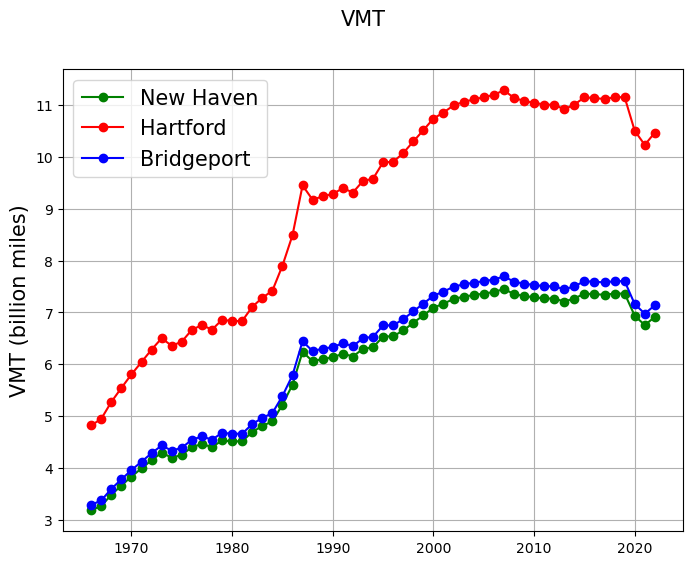

In [3]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('VMT',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (billion miles)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (billion miles)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (billion miles)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('VMT (billion miles)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/vmt-historical-change.png', dpi=600, bbox_inches='tight')

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Correlation and autocorrelation before and after differencing</span>

In [4]:
HEM_data = df['Hartford (billion miles)']
NHM_data = df['New Haven (billion miles)']
BSN_data = df['Bridgeport (billion miles)']

differenced_NHM = NHM_data.diff().dropna()
differenced_HEM = HEM_data.diff().dropna()
differenced_BSN = BSN_data.diff().dropna()

second_order_differenced_NHM = NHM_data.diff().diff().dropna()# the second order differencing will over difference the data

In [5]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [28]:
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

def evaluate_forecast(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = evaluate_forecast(test, pred_mean)
    
    # Calculate BIC and AIC
    #bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse

def performance_metric_order(data): 
    
    n_splits = 5  # You can adjust this value as needed

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,8)
    d_values = range(1,2)
    q_values = range(0,8)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                #bic_cv = []
                #aic_cv = []

                # Perform cross-validation
                for train_index, test_index in tscv.split(data):
                    train, test = data[train_index], data[test_index]
                    mape, mae, rmse = arima_prediction(train, test, order)
                    mape_cv.append(mape)
                    mae_cv.append(mae)
                    rmse_cv.append(rmse)
                    #bic_cv.append(bic) in-sample error-biased
                    #aic_cv.append(aic)

                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                #bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean})
                                        #BIC': bic_mean, 'AIC': aic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df

            
HEM_data = df['Hartford (billion miles)']
NHM_data = df['New Haven (billion miles)']
BSN_data = df['Bridgeport (billion miles)']
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=performance_metric_order(HEM_data)
results_df_NHM_cv=performance_metric_order(NHM_data)
results_df_BSN_cv=performance_metric_order(BSN_data)

print(results_df_BSN_cv)

    p  d  q       MAPE       MAE      RMSE
0   0  1  0   5.405851  0.352533  0.410482
1   0  1  1   4.780741  0.312285  0.369572
2   0  1  2   4.479664  0.291436  0.348795
3   0  1  3  14.172722  0.761376  0.807890
4   0  1  4   3.599396  0.230861  0.293348
.. .. .. ..        ...       ...       ...
59  7  1  3   8.102253  0.542381  0.653943
60  7  1  4  34.099611  2.247207  3.151000
61  7  1  5  34.107907  2.244842  3.186333
62  7  1  6  16.866771  1.104944  1.464130
63  7  1  7  38.323742  2.516361  3.639954

[64 rows x 6 columns]


In [29]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
test_BSN.sort_values(by='RMSE').iloc[:10,:]

MAPE       MAE      RMSE
p d q                              
0 1 4  3.599396  0.230861  0.293348
    5  4.361538  0.284530  0.339358
1 1 0  4.381449  0.287711  0.343456
0 1 2  4.479664  0.291436  0.348795
    1  4.780741  0.312285  0.369572
2 1 0  4.893344  0.320256  0.380438
1 1 2  4.723680  0.310911  0.400613
0 1 0  5.405851  0.352533  0.410482
2 1 2  5.108710  0.337950  0.411224
3 1 4  4.986931  0.328636  0.419936

In [30]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
test_HEM.sort_values(by='RMSE').iloc[:10,:]

MAPE       MAE      RMSE
p d q                              
0 1 4  3.664940  0.344863  0.434760
    6  3.468906  0.338979  0.437693
1 1 0  4.381449  0.422062  0.503837
0 1 2  4.479655  0.427526  0.511670
    1  4.780742  0.458112  0.542149
2 1 0  4.893344  0.469804  0.558089
    1  5.039804  0.479137  0.578941
1 1 2  4.723107  0.456041  0.587624
4 1 3  4.802524  0.465919  0.595750
0 1 0  5.405851  0.517154  0.602162

In [31]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
test_NHM.sort_values(by='RMSE').iloc[:10,:]

MAPE       MAE      RMSE
p d q                              
0 1 4  3.605307  0.223955  0.284399
1 1 0  4.381449  0.278644  0.332632
0 1 2  4.479646  0.282251  0.337803
    6  4.465672  0.285064  0.341358
    1  4.780741  0.302444  0.357926
2 1 0  4.893344  0.310164  0.368449
1 1 2  4.723636  0.301110  0.387986
0 1 0  5.405851  0.341424  0.397546
2 1 2  5.111680  0.327516  0.398538
0 1 7  5.782507  0.357181  0.415225

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">VMT forecast</span>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     Hartford (billion miles)   No. Observations:                   57
Model:                       ARIMA(0, 1, 4)   Log Likelihood                   5.371
Date:                      Thu, 11 Apr 2024   AIC                             -0.741
Time:                              19:48:47   BIC                              8.918
Sample:                          01-01-1966   HQIC                             2.950
                               - 01-01-2022                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3066      0.185      1.660      0.097      -0.055       0.668
ma.L2          0.1518      0.153      0.995      0.320      -0.147       0.451
ma.L3          0.1485      0.266      0.559      0.576      -0.373       0.670
ma.L4          0.2427      0.293      0.827      0.408      -0.332       0.818
sigma2         0.0473      0.006      7.820      0.000       0.035       0.059
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                37.49
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.37
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

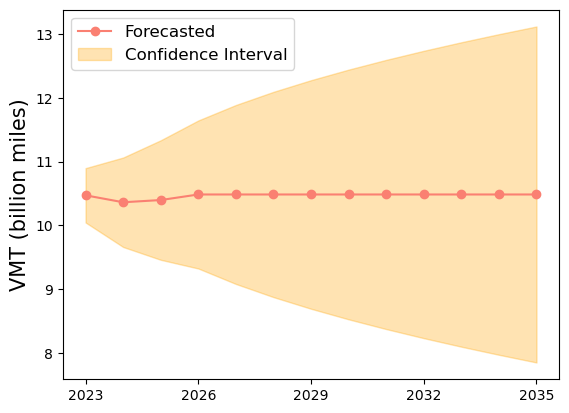

In [32]:
#In the arima model,p refers to how many previous/lagged Y values are accounted for for each time point in our model, and q refers to how many previous/lagged error values 
#are accounted for for each time point in our model

def arima_forecast(train, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2023, 2023 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res.summary(),forecast,confidence_interval

HEM_train = df_train['Hartford (billion miles)']
HEM_test = df_test['Hartford (billion miles)']
HEM_data = df['Hartford (billion miles)']
plot_file = '../../../figures/hartford-forecast-vmt.png'  # File to save the plot

summary, HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data,(0,1,4),13, plot_file,'salmon','orange')#chagne the function name. make function shorter; call old function in new function
summary

In [11]:
def arima_test_data_performance_metrics(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    return mae, rmse, mape

HEM_train = df_train['Hartford (billion miles)']
HEM_test = df_test['Hartford (billion miles)']
mae, rmse, mape = arima_test_data_performance_metrics(HEM_train, HEM_test,(0,2,8))
print(mae)
print(rmse)
print(mape)

0.19898552660120766
0.2501151175234218
1.8127310366433396


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     New Haven (billion miles)   No. Observations:                   57
Model:                        ARIMA(3, 0, 4)   Log Likelihood                  30.496
Date:                       Thu, 11 Apr 2024   AIC                            -42.992
Time:                               19:25:00   BIC                            -25.430
Sample:                           01-01-1966   HQIC                           -36.259
                                - 01-01-2022                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4631      1.505      4.959      0.000       4.513      10.413
ar.L1          1.0656      1.243      0.857      0.391      -1.370       3.502
ar.L2         -0.0955      1.734     -0.055      0.956      -3.495       3.304
ar.L3         -0.0103      1.385     -0.007      0.994      -2.725       2.704
ma.L1          0.1296      1.246      0.104      0.917      -2.312       2.571
ma.L2          0.0228      1.565      0.015      0.988      -3.044       3.090
ma.L3          0.0294      0.503      0.059      0.953      -0.956       1.014
ma.L4          0.1777      0.354      0.502      0.616      -0.517       0.872
sigma2         0.0184      0.003      6.320      0.000       0.013       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                35.83
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.02
Prob(H) (two-sided):                  0.23   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

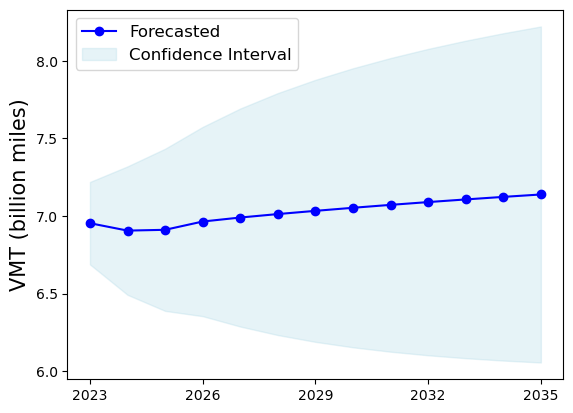

In [12]:
NHM_train = df_train['New Haven (billion miles)']
NHM_test = df_test['New Haven (billion miles)']
NHM_data = df['New Haven (billion miles)']
plot_file = '../../../figures/newhaven-forecast-VMT.png'  # File to save the plot


summary, NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data,(3,0,4),13, plot_file,'blue','lightblue')#chagne the function name. make function shorter; call old function in new function
summary

In [13]:
NHM_train = df_train['New Haven (billion miles)']
NHM_test = df_test['New Haven (billion miles)']
NHM_data = df['New Haven (billion miles)']
mae, rmse, mape = arima_test_data_performance_metrics(NHM_train, NHM_test,(0,2,8))
print(mae, rmse, mape)

0.1313347716737011 0.1650831055548571 1.8122673997818723


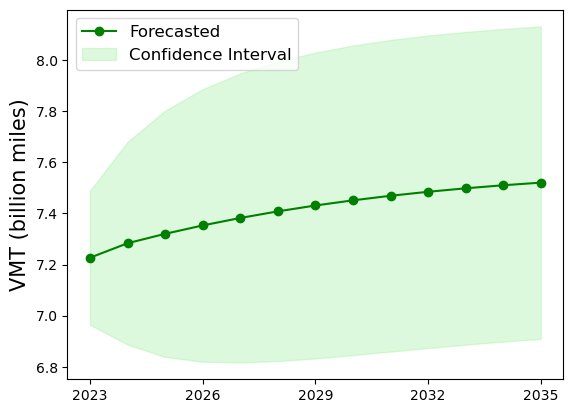

In [14]:
BSN_train = df_train['Bridgeport (billion miles)']
BSN_test = df_test['Bridgeport (billion miles)']
BSN_data = df['Bridgeport (billion miles)']
plot_file = '../../../figures/bridgeport-forecast-VMT.png'  # File to save the plot

summary, BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data,(2,0,3),13, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function

In [15]:
mae, rmse, mape = arima_test_data_performance_metrics(BSN_train, BSN_test,(7,2,1))
print(mae,rmse, mape)

0.15735359007240868 0.18264690297400848 2.1367233751365045


<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Emissions calculation</span>

In [16]:
import string
df_vehicle_re = pd.read_csv('../../../data/raw/mv1.csv')

df_vehicle_re = pd.read_csv('../../../data/raw/mv1.csv')

statewide_vehicle = df_vehicle_re.iloc[14, :]

# the total number of each vehicle type
statewide_automobile = statewide_vehicle.iloc[3]
statewide_buses = statewide_vehicle.iloc[6]
statewide_trucks = statewide_vehicle.iloc[9]
statewide_motorcycle = statewide_vehicle.iloc[12]
statewide_total = statewide_vehicle.iloc[15]

# ratio of each vehicle type to the total
statewide_automobile = int(str(statewide_automobile).translate(str.maketrans('', '', string.punctuation)))
statewide_buses = int(str(statewide_buses).translate(str.maketrans('', '', string.punctuation)))
statewide_trucks = int(str(statewide_trucks).translate(str.maketrans('', '', string.punctuation)))
statewide_motorcycle = int(str(statewide_motorcycle).translate(str.maketrans('', '', string.punctuation)))
statewide_total = int(str(statewide_total).translate(str.maketrans('', '', string.punctuation)))

automobile_rat = statewide_automobile / statewide_total
buses_rat = statewide_buses / statewide_total
trucks_rat = statewide_trucks / statewide_total
motorcycle_rat = statewide_motorcycle / statewide_total

statewide_vehicle = statewide_vehicle.to_numpy()

In [17]:
def emissions(VMT):
    automobile_vmt=VMT*automobile_rat
    buses_vmt=VMT*buses_rat
    trucks_vmt=VMT*trucks_rat
    motorcycle_vmt=VMT*motorcycle_rat

    #average MPG for each vehicle type ( miles per gallons)
    passenger_car_gasoline=24.1#automobile
    passenger_car_diesel=32.4
    light_truck_gasoline=18.5
    light_truck_diesel=22.1#trucks
    heavy_duty_gasoline=10.13
    heavy_duty_diesel=12.96#buses
    motorcycle_gasoline=50#motorcycle

    #emission factor for different fuels (kg CO2/gallon)( referenced from the ghg tool community module)
    gasoline=8.78
    diesel=10.21

    #calculate the fuel consumption in NH MSA
    gaso_consump= automobile_vmt/passenger_car_gasoline+motorcycle_vmt/motorcycle_gasoline
    dies_consump= buses_vmt/heavy_duty_diesel+trucks_vmt/light_truck_diesel

    #calcualte the gasoline and diesel emissions: carbon dioxide emissions only
    gaso_emissions =gaso_consump*gasoline/1000
    dies_emissions =dies_consump*diesel/1000

    #calculate the carbon dioxide consumption(metric tons):
    CO2=gaso_consump*gasoline/1000+dies_consump*diesel/1000

    gaso_auto=automobile_vmt/passenger_car_gasoline
    gaso_motor=motorcycle_vmt/motorcycle_gasoline
    die_trucks=trucks_vmt/light_truck_diesel
    die_buses=buses_vmt/heavy_duty_diesel

    #emission factor for different vehicles : g/miles ( referenced from EPA emission hub)
    # based on year 2005
    CH4_gaso_passenger_car=0.008
    N2O_gaso_passenger_car=0.007

    CH4_gaso_motorcycle=0
    N2O_gaso_motorcycle=0

    CH4_buses=0.005
    N2O_buses=0.005 #( meidum- heavy-duty vehicles in year 2005)

    CH4_trucks=0.001 #( light-duty trucks)
    N2O_trucks=0.001

    #calculate the CH4 emission (metric tons):
    CH4=automobile_vmt*CH4_gaso_passenger_car/1000000+motorcycle_vmt*CH4_gaso_motorcycle/1000000+buses_vmt*CH4_buses/1000000+trucks_vmt*CH4_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_1=CH4*25

    #calculate the N2O emission (metric tons):
    N2O = automobile_vmt*N2O_gaso_passenger_car/1000000 + motorcycle_vmt*N2O_gaso_motorcycle/1000000+buses_vmt*N2O_buses/1000000+trucks_vmt*N2O_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_2=N2O*298#define the number 

    #calculation of emissions from each types of vehicle,MMTCO2e(autombile, motorcycle, trucks, buses-NH,HH,BSN)
    automobile = (automobile_vmt/passenger_car_gasoline*gasoline/1000+automobile_vmt*CH4_gaso_passenger_car/1000000*25+automobile_vmt*N2O_gaso_passenger_car/1000000*298)*1000
    motorcycle = (motorcycle_vmt/motorcycle_gasoline*gasoline/1000+motorcycle_vmt*CH4_gaso_motorcycle/1000000*25+motorcycle_vmt*N2O_gaso_motorcycle/1000000*298)*1000
    buses = (buses_vmt/heavy_duty_diesel*diesel/1000+buses_vmt*CH4_buses/1000000*25+buses_vmt*N2O_buses/1000000*298)*1000
    trucks = (trucks_vmt/light_truck_diesel*diesel/1000+trucks_vmt*CH4_trucks/1000000*25+trucks_vmt*N2O_trucks/1000000*298)*1000

    total = automobile+motorcycle+buses+trucks
    
    return total

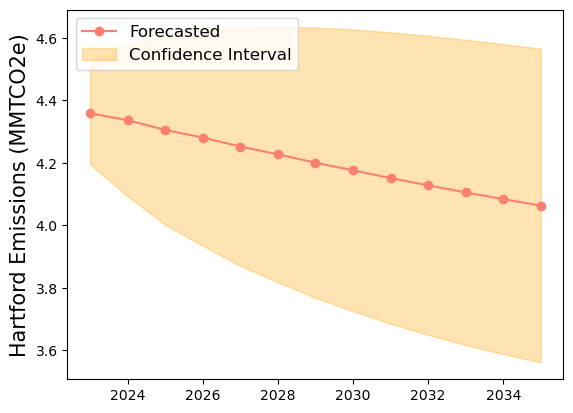

In [18]:
def VMT_plot(area, confidence_int,plot_title,plot_file, color1, color2):
    forecasted = emissions(area)
    confidence_interval_emissions = emissions(confidence_int)
    # Plot the forecasted values
    plt.plot(forecasted.index, forecasted, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecasted.index, confidence_interval_emissions.iloc[:, 0], confidence_interval_emissions.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel(plot_title, fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    plt.savefig(plot_file, dpi=600, bbox_inches='tight')
    
    return forecasted
    
plot_title = 'Hartford Emissions (MMTCO2e)'
plot_file = '../../../figures/hartford-forecast-emissions.png'  # File to save the plot
HEM_emissions_forecast=VMT_plot(HEM_forecast,HEM_confidence_interval,plot_title,plot_file,'salmon','orange')

In [19]:
HEM_emissions_forecast

2023    4.358884
2024    4.336529
2025    4.305521
2026    4.280811
2027    4.252281
2028    4.227122
2029    4.200546
2030    4.176028
2031    4.151318
2032    4.128106
2033    4.105343
2034    4.083859
2035    4.063171
Name: predicted_mean, dtype: float64

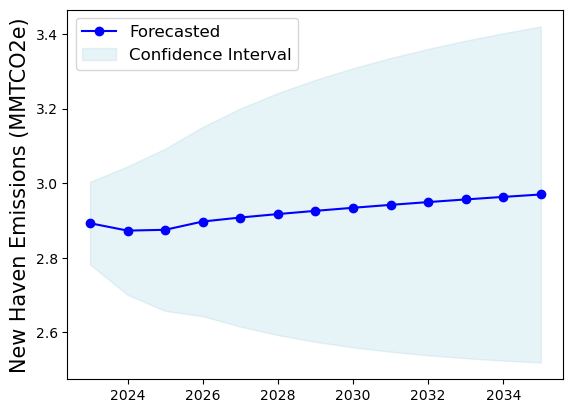

In [20]:
plot_title = 'New Haven Emissions (MMTCO2e)'
plot_file = '../../../figures/newhaven-forecast-emissions.png'  # File to save the plot
NHM_emissions_forecast=VMT_plot(NHM_forecast,NHM_confidence_interval,plot_title,plot_file,'blue','lightblue')

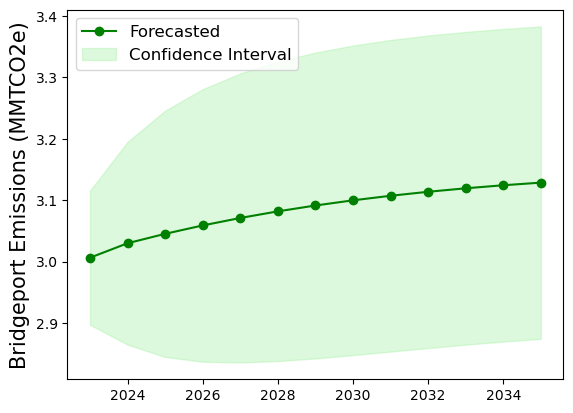

In [21]:
plot_title = 'Bridgeport Emissions (MMTCO2e)'
plot_file = '../../../figures/bridgeport-forecast-emissions.png'  # File to save the plot
BSN_emissions_forecast=VMT_plot(BSN_forecast,BSN_confidence_interval,plot_title,plot_file,'green','lightgreen')

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Fitting training data</span>

In [22]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean
    train_conf_int = train_forecast.conf_int()
        
    #train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    #train_conf_int = train_forecast.conf_int().iloc[

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()

    emissions_train = emissions(train_forecast_mean)
    
    train_conf_int = emissions(train_conf_int)
    
    return emissions_train,train_conf_int
    
    
HEM_train = df_train['Hartford (billion miles)']
HEM_test = df_test['Hartford (billion miles)']
emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(3,0,3))

NHM_train = df_train['New Haven (billion miles)']
NHM_test = df_test['New Haven (billion miles)']
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(3,0,4))

BSN_train = df_train['Bridgeport (billion miles)']
BSN_test = df_test['Bridgeport (billion miles)']
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(2,0,3))

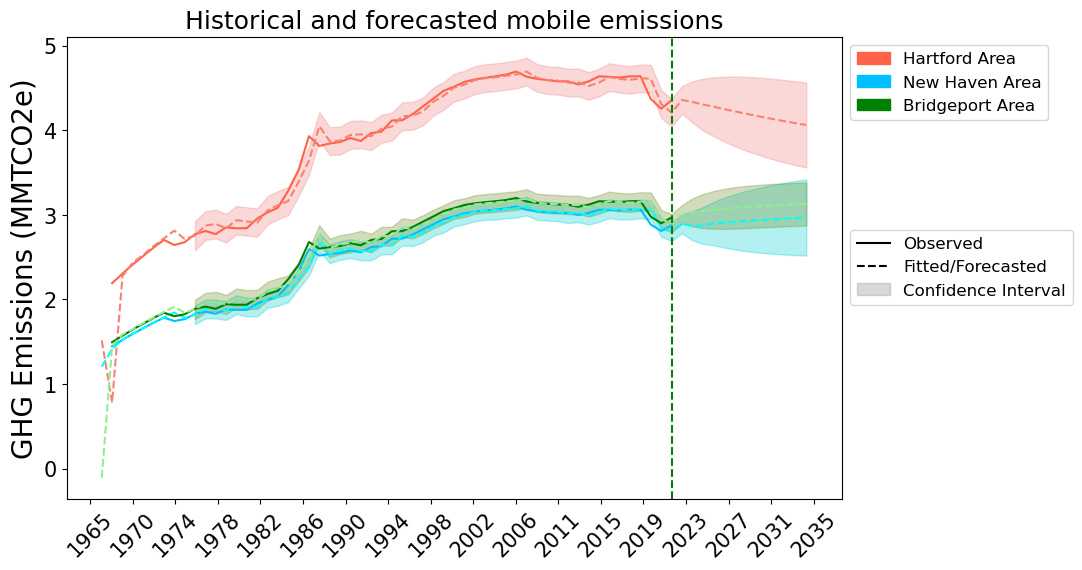

In [23]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([emissions(HEM_train),emissions(HEM_test)])[2:]
HEM_emissions_forecast.index = pd.to_datetime(HEM_emissions_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM[1:],HEM_emissions_forecast])

#HEM_emissions_forecast.index = pd.to_datetime(HEM_emissions_forecast.index, format='%Y')
plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, emissions(HEM_confidence_interval)])
plt.fill_between(concatenated_confidence_interval_HEM[10:].index, concatenated_confidence_interval_HEM.iloc[10:, 0], concatenated_confidence_interval_HEM.iloc[10:, 1], color='lightcoral', alpha=0.3)


concatenated_observed_NHM = pd.concat([emissions(NHM_train),emissions(NHM_test)])[2:]
NHM_emissions_forecast.index = pd.to_datetime(NHM_emissions_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM[1:],NHM_emissions_forecast])

plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='deepskyblue')
plt.plot(concatenated_predicted_forecast_NHM.index, concatenated_predicted_forecast_NHM, label='New Haven_Fitted', color='cyan', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, emissions(NHM_confidence_interval)])
plt.fill_between(concatenated_confidence_interval_NHM[10:].index, concatenated_confidence_interval_NHM.iloc[10:, 0], concatenated_confidence_interval_NHM.iloc[10:, 1], color='darkturquoise', alpha=0.3)

#plt.plot(NHM_emissions_forecast.index, NHM_emissions_forecast, color='darkturquoise', label='New Haven_Forecasted',linestyle='--')
#plt.fill_between(NHM_emissions_forecast.index, emissions(NHM_confidence_interval).iloc[:, 0], emissions(NHM_confidence_interval).iloc[:, 1], color='darkturquoise', alpha=0.3)
#plt.fill_between(emissions_train_NHM[10:].index, train_conf_int_NHM.iloc[10:, 0], train_conf_int_NHM.iloc[10:, 1], color='darkturquoise', alpha=0.3)


concatenated_observed_BSN = pd.concat([emissions(BSN_train),emissions(BSN_test)])[2:]
BSN_emissions_forecast.index = pd.to_datetime(BSN_emissions_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN[1:],BSN_emissions_forecast])

plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN.index, concatenated_predicted_forecast_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, emissions(BSN_confidence_interval)])
plt.fill_between(concatenated_confidence_interval_BSN[10:].index, concatenated_confidence_interval_BSN.iloc[10:, 0], concatenated_confidence_interval_BSN.iloc[10:, 1], color='olivedrab', alpha=0.3)




# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='deepskyblue', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch,green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Historical and forecasted mobile emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)

plt.xticks(fontsize=15, rotation=45) 
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')


plt.savefig('../../../figures/mobile_emissions_forecast.png', dpi=600, bbox_inches='tight')

In [24]:
concatenated_confidence_interval_HEM

,lower Hartford (billion miles),upper Hartford (billion miles)
1966-01-01,-811.338632,819.377121
1967-01-01,-813.840904,816.874881
1968-01-01,-814.576380,816.139406
1969-01-01,-813.080935,817.634865
1970-01-01,2.238784,2.633719
...,...,...
2031-01-01,3.684911,4.617726
2032-01-01,3.649496,4.606716
2033-01-01,3.616871,4.593816
2034-01-01,3.587726,4.579993


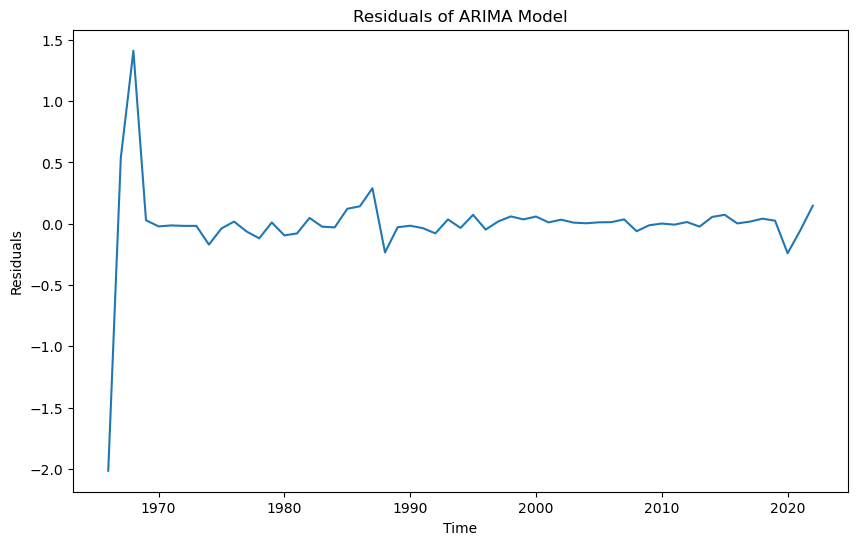

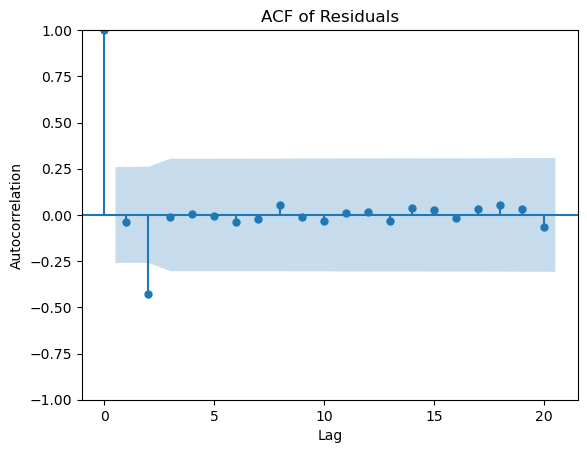

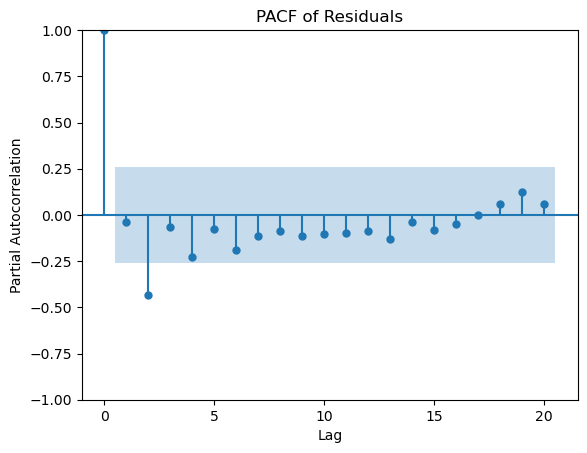

Ljung-Box Test Statistic: lb_stat
Ljung-Box Test p-value: lb_pvalue
ADF Test Statistic: -12.280843487652131
ADF Test p-value: 8.230591393435722e-23
Critical Values: {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}


NameError: name 'sns' is not defined

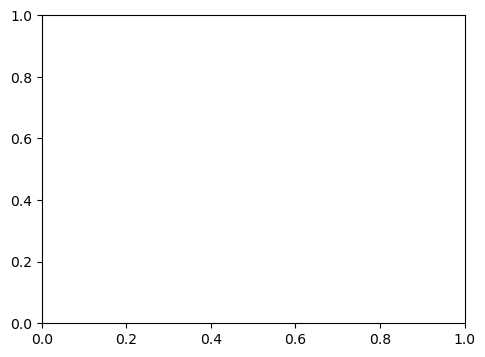

In [25]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

# Get residuals
residuals = emissions(HEM_data) - emissions_train_HEM

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# ACF plot of residuals
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# PACF plot of residuals
plot_pacf(residuals, lags=20)
plt.title('PACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Ljung-Box test for autocorrelation
lb_test_stat, lb_p_value = acorr_ljungbox(residuals, lags=20)
print(f'Ljung-Box Test Statistic: {lb_test_stat}')
print(f'Ljung-Box Test p-value: {lb_p_value}')

# Augmented Dickey-Fuller test for stationarity
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(residuals)
print(f'ADF Test Statistic: {adf_test_stat}')
print(f'ADF Test p-value: {adf_p_value}')
print(f'Critical Values: {adf_critical_values}')

# Plot histogram and Q-Q plot of the residuals
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()
